# Libraries

In [12]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

from pep_modules import patientai as pai

In [3]:
def plot_roc_curve(y_true, y_score, roc_auc_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=(10,7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Loading data

In [4]:
cross_df = pd.read_pickle(r'../data/cross_data.pkl')
targets_df = pd.read_pickle(r'../data/target.pkl')

x_train_static = pd.read_pickle(r'../data/train_static.pkl')
x_val_static = pd.read_pickle(r'../data/val_static.pkl')
x_test_static = pd.read_pickle(r'../data/test_static.pkl')

In [5]:
print(cross_df.shape)
cross_df.head()

(45980, 4)


,pat_id,journey,event_day,marked_journey
0,2,"[NEO*IV*Gentamicin, Syringe (Neonatal) *D5W*, ...","[1, 2, 3, 4, 5, 6, 7, 8]","[NEO*IV*Gentamicin, Syringe (Neonatal) *D5W*, ..."
1,3,"[966.0, 3893.0, 9672.0, 8964.0, 9962.0, 9604.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[966.0, 3893.0, 9672.0, 8964.0, 9962.0, 9604.0..."
2,4,"[D5W, Vancomycin HCl, Potassium Chloride, Insu...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[D5W, Vancomycin HCl, Potassium Chloride, Insu..."
3,5,"[9955.0, V290, V053, V3000]","[1, 2, 3, 4]","[9955.0, V290, V053, V3000]"
4,6,"[Tacrolimus, Tacrolimus, Valganciclovir HCl, W...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[Tacrolimus, Tacrolimus, Valganciclovir HCl, W..."


In [6]:
# CLass imbalance
targets_df.switch_flag.sum()*100/len(targets_df)

3.357981731187473

In [7]:
X1, X_test, y1, y_test = train_test_split(cross_df, targets_df, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.15, random_state=42)

# Best Results

In [15]:
# best parameters without and with static features
w2v_dim_static = 64
jlen_static = 120

w2v_dim = 64
jlen = 120

## Without static 

In [10]:
loaded_word2vec = Word2Vec.load(f'../saved_models/word2vec_{w2v_dim}.model')

In [13]:
x_train_tensor, y_train_tensor = pai.get_all_tensors_deepr(X_train,'journey',
                                                                 y_train,'switch_flag',loaded_word2vec,jlen)
x_val_tensor, y_val_tensor = pai.get_all_tensors_deepr(X_val,'journey',
                                                             y_val,'switch_flag',loaded_word2vec,jlen)
x_test_tensor, y_test_tensor = pai.get_all_tensors_deepr(X_test,'journey',
                                                               y_test,'switch_flag',loaded_word2vec,jlen)

x_train_tensor = np.squeeze(x_train_tensor)
x_val_tensor = np.squeeze(x_val_tensor)
x_test_tensor = np.squeeze(x_test_tensor)

x_train_tensor = x_train_tensor.transpose((0,2,1))
x_val_tensor = x_val_tensor.transpose((0,2,1))
x_test_tensor = x_test_tensor.transpose((0,2,1))

print(x_train_tensor.shape, x_val_tensor.shape, x_test_tensor.shape)

(31266, 120, 64) (5518, 120, 64) (9196, 120, 64)


In [18]:
model = pai.build_lstm(jlen, w2v_dim)
model.load_weights(f'../saved_models/lstm_tuning/lstm_w2v{w2v_dim}_jlen{jlen}.h5')

In [19]:
trn_result = model.evaluate(x_train_tensor,y_train_tensor)

31266/31266 [==============================] - 14s 434us/sample - loss: 0.1146 - my_auc: 0.8233


In [20]:
val_results = model.evaluate(x_val_tensor,y_val_tensor)

5518/5518 [==============================] - 2s 379us/sample - loss: 0.1586 - my_auc: 0.6573


In [21]:
test_results = model.evaluate(x_test_tensor,y_test_tensor)
y_test_pred = model.predict(x_test_tensor)

9196/9196 [==============================] - 4s 398us/sample - loss: 0.1451 - my_auc: 0.6739


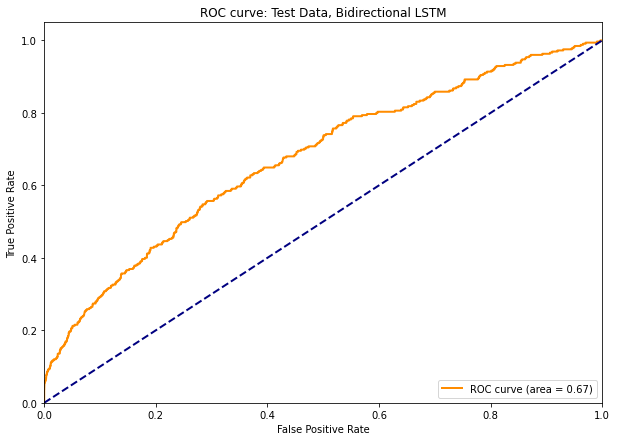

In [22]:
plot_roc_curve(y_test_tensor, y_test_pred, test_results[1], 'ROC curve: Test Data, Bidirectional LSTM')

# Static Features

In [23]:
loaded_word2vec = Word2Vec.load(f'../saved_models/word2vec_{w2v_dim_static}.model')

In [24]:
x_train_tensor, y_train_tensor = pai.get_all_tensors_deepr(X_train,'journey',
                                                                 y_train,'switch_flag',loaded_word2vec,jlen_static)
x_val_tensor, y_val_tensor = pai.get_all_tensors_deepr(X_val,'journey',
                                                             y_val,'switch_flag',loaded_word2vec,jlen_static)
x_test_tensor, y_test_tensor = pai.get_all_tensors_deepr(X_test,'journey',
                                                               y_test,'switch_flag',loaded_word2vec,jlen_static)

x_train_tensor = np.squeeze(x_train_tensor)
x_val_tensor = np.squeeze(x_val_tensor)
x_test_tensor = np.squeeze(x_test_tensor)

x_train_tensor = x_train_tensor.transpose((0,2,1))
x_val_tensor = x_val_tensor.transpose((0,2,1))
x_test_tensor = x_test_tensor.transpose((0,2,1))

print(x_train_tensor.shape, x_val_tensor.shape, x_test_tensor.shape)

(31266, 120, 64) (5518, 120, 64) (9196, 120, 64)


In [25]:
model = pai.build_lstm(jlen_static, w2v_dim_static, n_static=182)
model.load_weights(f'../saved_models/lstm_tuning/static_lstm_w2v{w2v_dim_static}_jlen{jlen_static}.h5')

In [26]:
trn_result = model.evaluate([x_train_tensor,x_train_static],y_train_tensor)

31266/31266 [==============================] - 11s 355us/sample - loss: 0.1056 - my_auc: 0.8741


In [27]:
val_results = model.evaluate([x_val_tensor, x_val_static],y_val_tensor)

5518/5518 [==============================] - 2s 338us/sample - loss: 0.1497 - my_auc: 0.7364


In [28]:
test_results = model.evaluate([x_test_tensor,x_test_static],y_test_tensor)
y_test_pred = model.predict([x_test_tensor,x_test_static])

9196/9196 [==============================] - 3s 342us/sample - loss: 0.1381 - my_auc: 0.7402


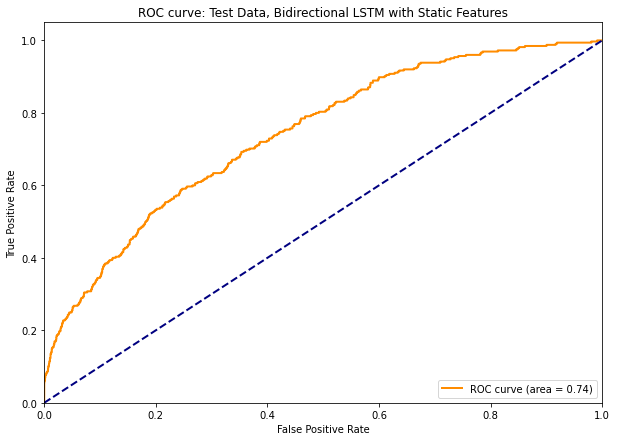

In [29]:
plot_roc_curve(y_test_tensor, y_test_pred, test_results[1], 'ROC curve: Test Data, Bidirectional LSTM with Static Features')